In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
price_data = pd.read_csv('../data/processed/canada_subcategories.csv')
price_data.head()

,Category,Time,Price Index
0,Nonmanufactory,19-Dec,-0.015017
1,Nonmanufactory,20-Jan,-0.029362
2,Nonmanufactory,20-Feb,-0.136126
3,Nonmanufactory,20-Mar,-0.284848
4,Nonmanufactory,20-Apr,-0.411488


In [9]:
policy_data = pd.read_csv('../data/OxCGRT_latest.csv')
ca_policy_data = policy_data[policy_data['CountryName'] == 'Canada'].copy()
# ca_policy_data.drop(columns=['Country', 'Price Index'], inplace=True)

/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
cols = ['CountryName', 'RegionName', 'Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 
        'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement', 'C8_International travel controls', 
        'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex']
ca_policy_data = ca_policy_data[cols].copy()

In [12]:
ca_policy_data['Date'] = pd.to_datetime(ca_policy_data['Date'], format="%Y%m%d")

ca_policy_data = ca_policy_data.fillna(0)
ca_policy_data['month'] = ca_policy_data['Date'].apply(lambda x: str(x.year) + '-' + str(x.month))

In [15]:
agg_data = ca_policy_data.groupby(['month']).mean().reset_index()

In [17]:
agg_data['log_cases'] = np.log1p(agg_data['ConfirmedCases'])
agg_data['log_death'] = np.log1p(agg_data['ConfirmedDeaths'])

In [20]:
agg_data['month'] = pd.to_datetime(agg_data['month'])
price_data['month'] = pd.to_datetime(price_data['Time'], format="%y-%b")

In [33]:
ca_policy = pd.merge(price_data, agg_data, on=['month'])
ca_policy['date'] = ca_policy['month'].dt.to_period('M') - pd.to_datetime('2020-01-01').to_period('M')
ca_policy['date'] = ca_policy['date'].apply(lambda x: x.n)
# ca_policy.to_csv('../data/processed/ca_policy.csv', index=False)

In [39]:
ca_policy.columns

Index(['Category', 'Time', 'Price Index', 'month', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'ConfirmedCases', 'ConfirmedDeaths',
       'StringencyIndex', 'log_cases', 'log_death', 'date'],
      dtype='object')

In [2]:
def regression_analysis(data_path):
    data = pd.read_csv(data_path)
    data.columns = [x.replace(' ', '_') for x in data.columns]
#     print(data.columns)
#     vc = {'Country': '0 + C(Country)'}
    md = smf.mixedlm('Price_Index ~ date + C1_School_closing + C2_Workplace_closing + C3_Cancel_public_events + C4_Restrictions_on_gatherings + C5_Close_public_transport + C6_Stay_at_home_requirements + C7_Restrictions_on_internal_movement + C8_International_travel_controls + log_cases + log_death',
                     
                re_formula='~ C8_International_travel_controls', data=data, groups='Category')
    mdf = md.fit(method=["lbfgs"])
    print(mdf.summary())
    
    return mdf

In [3]:
mdf = regression_analysis('../data/processed/ca_policy.csv')

                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            Price_Index
No. Observations:            108                Method:                        REML       
No. Groups:                  4                  Scale:                         0.0087     
Min. group size:             27                 Log-Likelihood:                68.7976    
Max. group size:             27                 Converged:                     No         
Mean group size:             27.0                                                         
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       -0.155    0.127 -1.228 0.220 -0.403  0.093
date                      

/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.807946
  warnings.warn(msg, ConvergenceWarning)
/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/wenqianzhang/opt/anaconda3/lib/python3.8/site-packages/s

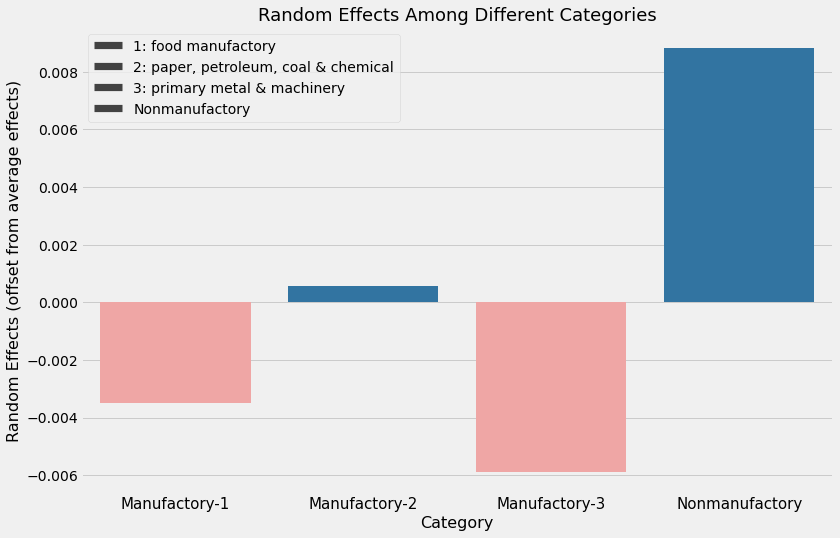

In [8]:
re_category = pd.DataFrame(mdf.random_effects).T

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")


fig = plt.figure(figsize=(12, 8))
sns.barplot(x=re_category.index, y=re_category['C8_International_travel_controls'], 
            palette=[sns.color_palette("Paired")[4], sns.color_palette("Paired")[1], sns.color_palette("Paired")[4],
                  sns.color_palette("Paired")[1]])
plt.title("Random Effects Among Different Categories", fontsize=18)
g = plt.xticks(fontsize=15)
plt.xlabel("Category", fontsize=16)
plt.ylabel("Random Effects (offset from average effects)", fontsize=16)
plt.legend(['1: food manufactory', '2: paper, petroleum, coal & chemical', '3: primary metal & machinery', 
            'Nonmanufactory'])
plt.savefig('../images/re_viz_ca.png', dpi=300, bbox_inches='tight')